In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from arch import arch_model
from arch.__future__ import reindexing
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import scipy
from scipy.optimize import minimize


In [2]:
# Read in the CSV file as a pandas DataFrame
df = pd.read_csv('/Users/anushreegupta/Downloads/MSAM/Applied Statistics/HistoricalData_1677625629476.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Convert the 'Close' column to string type
df['Close'] = df['Close'].astype(str)

# Remove commas from the 'Close' column
df['Close'] = df['Close'].str.replace(',', '')

# Convert the 'Close' column to float type
df['Close'] = df['Close'].astype(float)


In [3]:
# Display the first 10 rows of the DataFrame df
df.head(10)

,Date,Close,Open,High,Low
0,2023-02-27,3982.24,3992.36,4018.05,3973.55
1,2023-02-24,3970.04,3973.24,3978.25,3943.08
2,2023-02-23,4012.32,4018.60,4028.30,3969.19
3,2023-02-22,3991.05,4001.83,4017.37,3976.90
4,2023-02-21,3997.34,4052.35,4052.35,3995.19
5,2023-02-17,4079.09,4077.39,4081.51,4047.95
6,2023-02-16,4090.41,4114.75,4136.54,4089.49
7,2023-02-15,4147.60,4119.50,4148.11,4103.98
8,2023-02-14,4136.13,4126.70,4159.77,4095.01
9,2023-02-13,4137.29,4096.62,4138.90,4092.67


In [4]:
# Create a scatter plot of the 'Close' column
fig = go.Figure(data=go.Scatter(x=df['Date'][:252], y=df['Close'][:252], mode='lines', name = 'Close'))

# Add a second scatter plot of the 'Open' column to the same figure
fig.add_scatter(x=df['Date'][:252], y=df['Open'][:252], name = 'Open')

# Update the layout of the figure
fig.update_layout(title='Date vs Open/Close of F.Y. 2022-23', xaxis_title='Date', yaxis_title='Open/Close')

# Display the figure
fig.show()


In [5]:
fig = go.Figure(data=go.Scatter(x=df['Date'][:252],y=df['High'][:252], mode='lines', name = 'High'))
# Add Scatter plot
fig.add_scatter(x=df['Date'][:252], y=df['Close'][:252], name = 'Close')
fig.update_layout(title='Date vs High/Close of F.Y. 2022-23',xaxis_title='Date', yaxis_title='High/Close') 

fig.show()

In [7]:
fig = go.Figure(data=go.Scatter(x=df['Date'][:252],y=df['Low'][:252], mode='lines', name = 'Low'))
# Add Scatter plot
fig.add_scatter(x=df['Date'][:252], y=df['Open'][:252], name = 'Open')
fig.update_layout(title='Date vs Low/Open of F.Y. 2022-23',xaxis_title='Date', yaxis_title='Low/Open') 

fig.show()

In [8]:
df['Open'].describe()

count    2541.000000
mean     2754.618343
std       909.123767
min         0.000000
25%      2058.190000
50%      2626.240000
75%      3350.920000
max      4804.510000
Name: Open, dtype: float64

In [9]:
df['Close'].describe()

count    2541.000000
mean     2773.168272
std       872.500021
min      1514.680000
25%      2061.020000
50%      2629.570000
75%      3349.160000
max      4796.560000
Name: Close, dtype: float64

In [10]:
# Calculate the daily returns of a stock using the 'Close' price column of a pandas DataFrame
daily_returns = df['Close'].pct_change()

# Define a rolling window size of n days
n = 5

# Calculate the realized volatility using a rolling window of size n
realized_volatility = daily_returns.rolling(window=n).std() * np.sqrt(n)

In [11]:
realized_volatility.describe()

count    2536.000000
mean        0.019198
std         0.016674
min         0.001183
25%         0.009391
50%         0.014815
75%         0.023898
max         0.218600
Name: Close, dtype: float64

Text(0.5, 1.0, 'PLOT OF ACTUAL VOLATILITY')

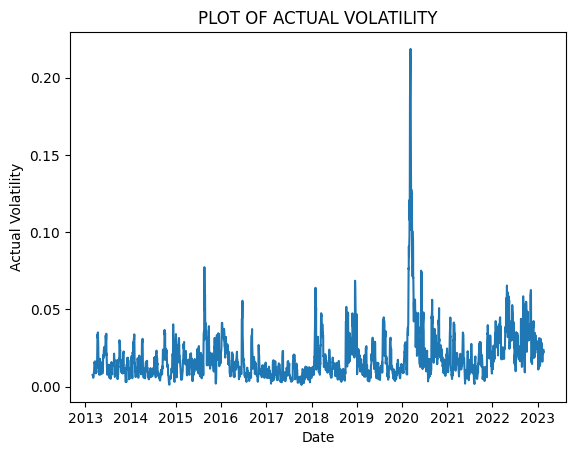

In [12]:
plt.plot(df['Date'],realized_volatility)
plt.xlabel("Date")
plt.ylabel("Actual Volatility")
plt.title('PLOT OF ACTUAL VOLATILITY')

In [13]:
# Create an empty list to store the rolling predictions
rolling_predictions = []

# Remove missing values from daily returns
daily_returns = daily_returns.dropna()

# Define the size of the test set
test_size = len(daily_returns)-1

# Loop over each time step in the test set
for i in range(test_size):
    # Ignore division by zero and invalid values
    np.seterr(divide='ignore', invalid='ignore')
    
    # Extract the returns up to the current time step
    returns = daily_returns[:-(test_size-i)]
    
    # Fit a GARCH(1,1) model to the returns
    model = arch_model(returns, p=1, q=1, vol='GARCH', rescale=False)
    model_fit = model.fit(disp='off')
    
    # Forecast the variance for the next 5 time steps
    pred = model_fit.forecast(horizon=5)
    
    # Append the square root of the variance to the rolling predictions list
    rolling_predictions.append(np.sqrt(pred.variance.values[0][0]))

/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.




In [135]:
# Initialize empty lists
rolling_predictions = []
aic = []
bic = []


# Remove NaN values from daily returns
daily_returns = daily_returns.dropna()
test_size = len(daily_returns)-1 # length of the test set

# Loop through p and q values
for p in range(1,10,1):
    for q in range(1,10,1):
        for i in range(test_size):
            # Set errors to ignore for numerical stability
            np.seterr(divide='ignore', invalid='ignore')
            # Slice the returns data up to the current index
            returns = daily_returns[:-(test_size-i)]
            # Fit the GARCH model with p, q values
            model = arch_model(returns, p=p, q=q, vol = 'GARCH', rescale=False)
            model_fit = model.fit(disp='off')
        # Append the AIC and BIC values to their respective lists
        aic.append(model_fit.aic)
        bic.append(model_fit.bic)

1      -0.003064
2       0.010650
3      -0.005301
4       0.001576
5       0.020451
          ...   
2536   -0.001813
2537   -0.001083
2538   -0.009475
2539   -0.004590
2540   -0.002319
Name: Close, Length: 2540, dtype: float64


/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for co

In [14]:
#Best-fit Model
for i in range(test_size):
    np.seterr(divide='ignore', invalid='ignore')
    returns = daily_returns[:-(test_size-i)]
    model = arch_model(returns, p=2, q=1, vol = 'GARCH', rescale=False)
    model_fit = model.fit(disp='off')
    
aic = model_fit.aic
bic = model_fit.bic

/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/anushreegupta/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




In [15]:
import statsmodels.api as sm
lb_test = sm. stats.diagnostic.acorr_ljungbox(daily_returns.dropna(), lags= [10])
print (lb_test)

       lb_stat     lb_pvalue
10  274.312172  4.123589e-53


In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(daily_returns.dropna(), lags=10)

lb_test

,lb_stat,lb_pvalue
1,49.736124,1.758777e-12
2,70.191153,5.730399e-16
3,70.562995,3.233686e-15
4,76.945698,7.722403e-16
5,83.606342,1.474958e-16
6,115.022002,1.806598e-22
7,171.684024,1.108268e-33
8,215.521938,3.399261e-42
9,264.741066,7.662683e-52
10,274.312172,4.123589e-53


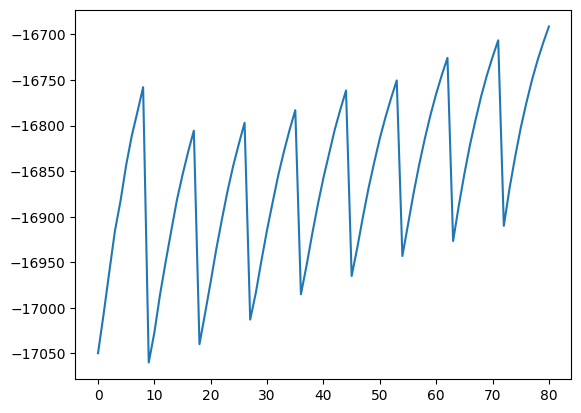

In [137]:
plt.plot(aic)

Text(0.5, 1.0, 'Plot of both Actual and Garch volatility')

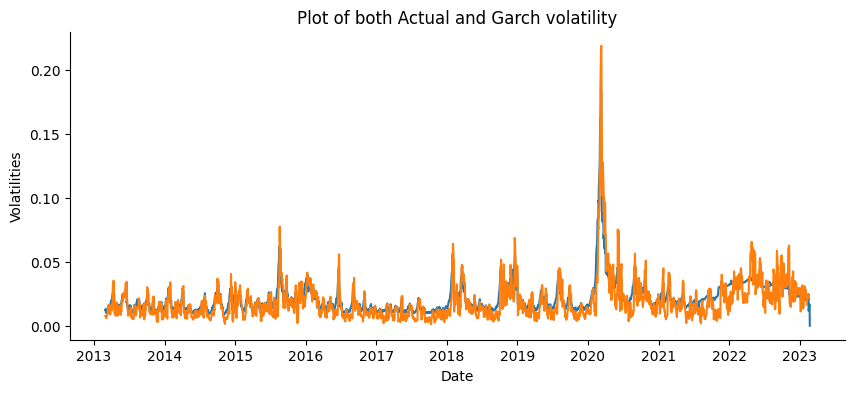

In [27]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Close'].index[-2539:]) 

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Date'][2:],(rolling_predictions * 5**0.5))
plt.plot(df['Date'],realized_volatility)
plt.xlabel("Date")
plt.ylabel("Volatilities")
plt.title('Plot of both Actual and Garch volatility')

In [28]:
from scipy.stats import jarque_bera

jb_test = jarque_bera(model_fit.resid)

jb_stats = jb_test[0]
jb_pval = jb_test[1]

print(jb_stats)
print(jb_pval)

36250.37437102552
0.0


In [29]:
jb_test

Jarque_beraResult(statistic=36250.37437102552, pvalue=0.0)

In [36]:
real_vol = realized_volatility.dropna()
rolling_vol = rolling_predictions[3:]

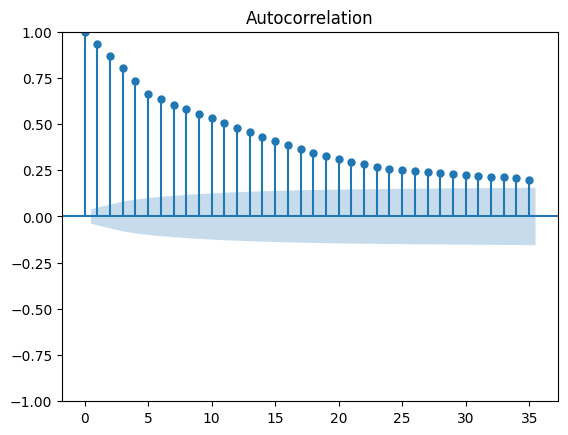

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(real_vol)
plt.show()

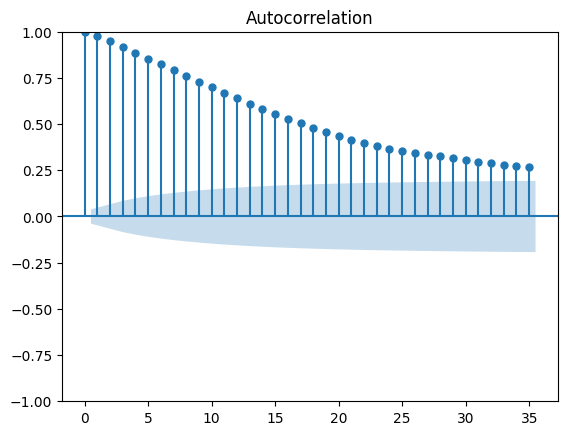

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rolling_vol)
plt.show()

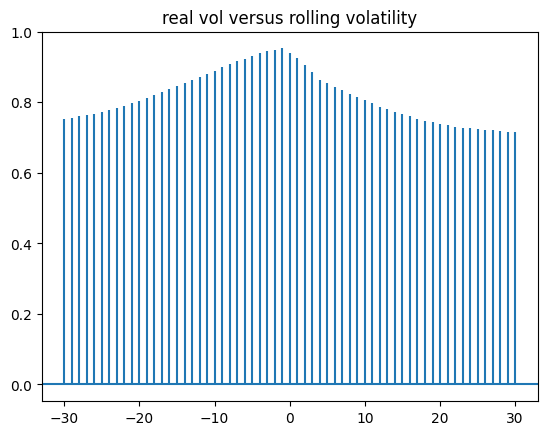

In [33]:
plt.xcorr(real_vol, rolling_vol, normed=True, usevlines=True, maxlags=30)
plt.title("real vol versus rolling volatility")
plt.show()

In [34]:
het_test = sm.stats.het_arch(model_fit.resid)
het_test

(965.1415547176754,
 6.0230211775011075e-201,
 155.3993868249614,
 3.42092223877066e-254)